In [26]:
import gym
import os
from stable_baselines.results_plotter import load_results
from seagul.plot import smooth_bounded_curve
import matplotlib.pyplot as plt
import numpy as np
import torch
import pybullet_envs
import pybulletgym
from stable_baselines import TD3 as ALGO
import time
import pybullet as p
import seagul.envs
import json

mj_env_name = "Walker2d-v2"
pb_env_name = "Walker2DMuJoCoEnv-v0"
sg_env_name = "pbmj_walker2d-v0"


dtype = torch.float32


physics_params = {
    'fixedTimeStep': 0.002,
    'numSubSteps': 0,
    'numSolverIterations': 50,
    'useSplitImpulse': 1,
    'splitImpulsePenetrationThreshold': -0.03999999910593033,
    'contactBreakingThreshold': 0.02,
    'collisionFilterMode': 1,
    'enableFileCaching': 1,
    'restitutionVelocityThreshold': 0.20000000298023224,
    'erp': 0.0,
    'frictionERP': 0.0,
    'contactERP': 0.0,
    'globalCFM': 0.0,
    'enableConeFriction': 0,
    'deterministicOverlappingPairs': 1,
    'allowedCcdPenetration': 0.04,
    'jointFeedbackMode': 0,
    'solverResidualThreshold': 1e-07,
    'contactSlop': 1e-05,
    'enableSAT': 0,
    'constraintSolverType': 0,
    'reportSolverAnalytics': 1,
}

dynamics_params = {
    'lateralFriction': 0.8,
    'restitution': 0.00,
    'rollingFriction': 0.1,
    'spinningFriction': 0.1,
    'contactDamping': 2e3,
    'contactStiffness': 6e5,
    'collisionMargin': 0.0,
    'angularDamping': 0.0,
    'linearDamping': 0.0,
    'jointDamping': .1,
}


def do_rollout_sg(render=False):
    env = gym.make(sg_env_name, render=render, physics_params=physics_params, dynamics_params=dynamics_params)
    obs = env.reset()
    model.observation_space = env.observation_space
    
    acts_list = []
    obs1_list = []
    rews_list = []

    obs1_list.append(obs)
    dtype = torch.float32
    obs = torch.as_tensor(obs, dtype=torch.float32)

    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0

    while not done:
        acts = model.predict(obs)[0]
        
        obs, rew, done, out = env.step(acts)
        
        obs1_list.append(obs)
        obs = torch.as_tensor(obs, dtype=dtype)

        acts_list.append(torch.as_tensor(acts))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list)
    ep_acts = torch.stack(acts_list)
    ep_rews = torch.stack(rews_list)
    print(p.getPhysicsEngineParameters())
    p.disconnect()

    return ep_obs1, ep_acts, ep_rews


def do_rollout_pb(render=False):
    env = gym.make(pb_env_name, render=render)
    obs = env.reset()
    model.observation_space = env.observation_space
    
    p.connect(p.DIRECT)
    p.setPhysicsEngineParameter(**physics_params)
    for j in env.env.robot.ordered_joints:
        p.changeDynamics(j.bodyIndex, j.jointIndex, **dynamics_params)
        print(j.jointIndex)
    #p.changeDynamics(1,-1,**dynamics_params)
    p.changeDynamics(0,-1,**dynamics_params)


    acts_list = []
    obs1_list = []
    rews_list = []

    
    #obs[0] += 1.25
    obs1_list.append(obs)
    dtype = torch.float32
    obs = torch.as_tensor(obs, dtype=torch.float32)

    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0


    while not done:
        acts = model.predict(obs)[0]
        
        #import ; ipdb.set_trace()


        obs, rew, done, out = env.step(acts)
        
        #obs[0] += 1.25
        obs1_list.append(obs)
        obs = torch.as_tensor(obs, dtype=dtype)

        acts_list.append(torch.as_tensor(acts))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list)
    ep_acts = torch.stack(acts_list)
    ep_rews = torch.stack(rews_list)
    p.disconnect()

    return ep_obs1, ep_acts, ep_rews

def do_rollout_mj(init_point=None, render=False):
    env = gym.make(mj_env_name)
    model.observation_space = env.observation_space
    #td3_model = TD3.load(script_path + "../rl-baselines-zoo/baseline_log2/td3/su_acrobot_cdc-v0_2/su_acrobot_cdc-v0.zip")

    if init_point is not None:
        obs = env.reset(init_point)
    else:
        obs = env.reset()
      
    
    acts_list = []
    obs1_list = []
    rews_list = []
    #obs1_list.append(obs)
    obs1_list.append(np.concatenate([np.copy(env.sim.data.qpos), np.copy(env.sim.data.qvel)]))

    obs = torch.as_tensor(obs, dtype=dtype)

    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0

    i = 0
    while not done:
        #acts = model.predict(obs)[0]
        acts = act_hist_ref[i]; i+=1
        #import ipdb; ipdb.set_trace()


        obs, rew, done, out = env.step(acts)

        if render:
            env.render()
            
        #obs1_list.append(obs)
        obs1_list.append(np.concatenate([np.copy(env.sim.data.qpos), np.copy(env.sim.data.qvel)]))
        obs = torch.as_tensor(obs, dtype=dtype)

        acts_list.append(torch.as_tensor(acts))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list)
    ep_acts = torch.stack(acts_list)
    ep_rews = torch.stack(rews_list)

    return ep_obs1, ep_acts, ep_rews

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


<Figure size 432x288 with 0 Axes>

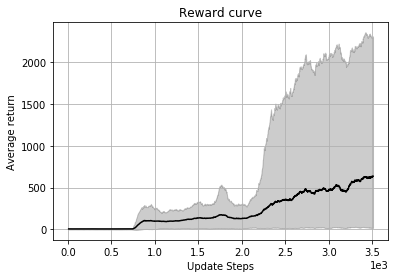

<Figure size 432x288 with 0 Axes>

In [27]:
# %%
fig, ax = plt.subplots(1,1)

#log_dir = script_path + './walker_log'
df_list = []
model_list = []
min_length = float('inf')

#trial_path = "/home/sgillen/work/lorenz/run_stable/data/mj15/td30/"
#trial_path = "/home/sgillen/work/lorenz/run_stable/data/bf/0"
trial_path = "/home/sgillen/work/contact/run_stable/data_pb/td32/"

for entry in os.scandir(trial_path):
    if ".ipynb" in entry.path:
        continue
    if "config" in entry.path:
        config = json.load(open(entry.path))
        continue
    
    df = load_results(entry.path)


    if len(df['r']) < min_length:
        min_length = len(df['r'])

    df_list.append(df)
    model_list.append(ALGO.load(entry.path + "/model.zip"))

min_length = int(min_length)
rewards = np.zeros((min_length, len(df_list)))

for i, df in enumerate(df_list):
    rewards[:, i] = np.array(df['r'][:min_length])

smooth_bounded_curve(rewards[:min_length], ax=ax)
 
ax.grid()
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#fig.savefig(script_path + '../figs/reward.png')
plt.figure() 

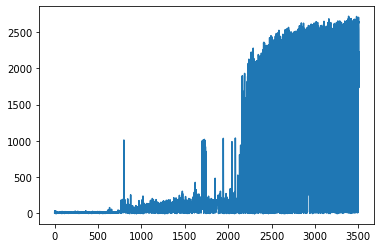

Creating window glfw
reward sum: -2.2495713233947754


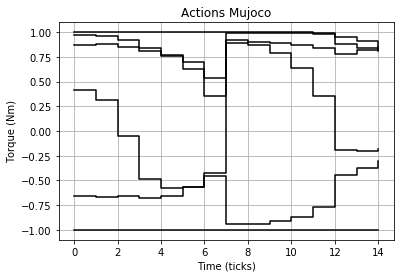

tensor([ 0.9732,  0.8716,  0.9999, -0.6596, -0.9999,  0.4154])


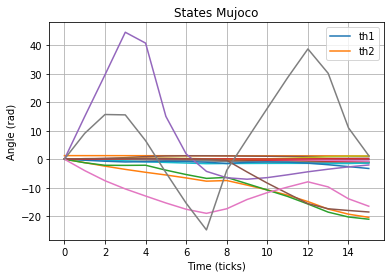

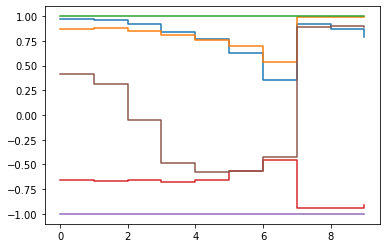

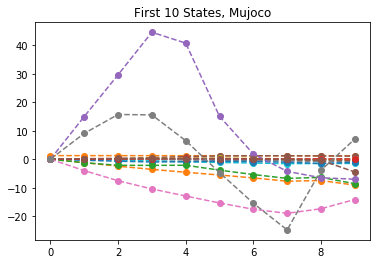

In [30]:
model = model_list[7]
df = df_list[7]
plt.plot(df['r']); plt.show()

obs_hist, act_hist, rew_hist = do_rollout_mj(render=True)

print(f"reward sum: {sum(rew_hist)}")

plt.step(act_hist, 'k',where='post')
plt.title('Actions Mujoco')
plt.xlabel('Time (ticks)')
plt.ylabel('Torque (Nm)')
plt.grid()
#plt.savefig(script_path + '../figs/act_hist.png')
plt.show(); plt.figure()

plt.plot(obs_hist)

plt.title('States Mujoco')
plt.xlabel('Time (ticks)')
plt.ylabel('Angle (rad)')
plt.legend(['th1', 'th2'])
plt.grid()
#plt.savefig(script_path + '../figs/obs_hist.png')
plt.figure()

le=10
plt.step([t for t in range(le)], act_hist[0:le], where='post')
plt.figure()
plt.plot(obs_hist[0:le], "o--")
plt.title(f"First {le} States, Mujoco")

print(act_hist[0])

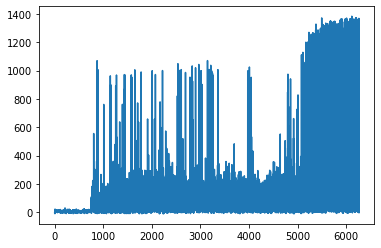

{'fixedTimeStep': 0.002, 'numSubSteps': 0, 'numSolverIterations': 50, 'useRealTimeSimulation': 0, 'gravityAccelerationX': 0.0, 'gravityAccelerationY': 0.0, 'gravityAccelerationZ': -9.8}
reward sum: 895.5135498046875


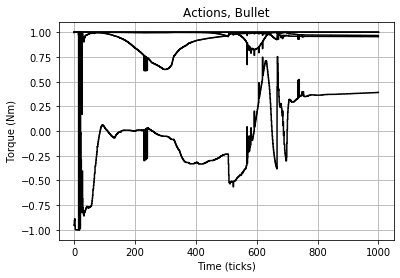

tensor([ 1.0000,  1.0000,  1.0000, -0.9531,  0.9968,  1.0000])


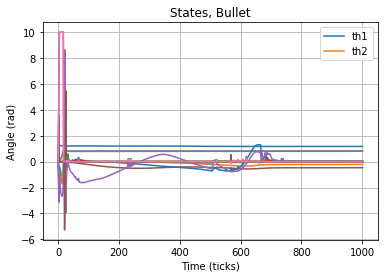

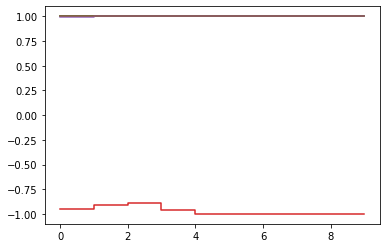

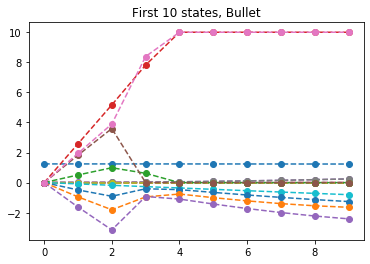

In [31]:
model = model_list[0]
df = df_list[0]
plt.plot(df['r']); plt.show()

obs_hist, act_hist, rew_hist = do_rollout_sg(render=True)

print(f"reward sum: {sum(rew_hist)}")

plt.step(act_hist, 'k',where='post')
plt.title('Actions, Bullet')
plt.xlabel('Time (ticks)')
plt.ylabel('Torque (Nm)')
plt.grid()
#plt.savefig(script_path + '../figs/act_hist.png')
plt.show(); plt.figure()

plt.plot(obs_hist)

plt.title('States, Bullet')
plt.xlabel('Time (ticks)')
plt.ylabel('Angle (rad)')
plt.legend(['th1', 'th2'])
plt.grid()
#plt.savefig(script_path + '../figs/obs_hist.png')
plt.figure()

le=10
plt.step([t for t in range(le)], act_hist[0:le], where='post')
plt.figure()
plt.plot(obs_hist[0:le], "o--")
plt.title(f"First {le} states, Bullet")

print(act_hist[0])

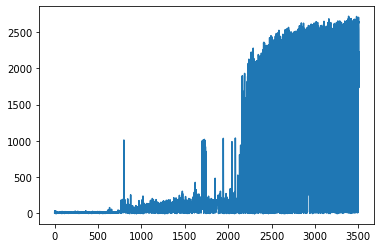

WalkerBase::__init__
0
1
2
4
6
8
10
12
14
reward sum: 1086.247802734375


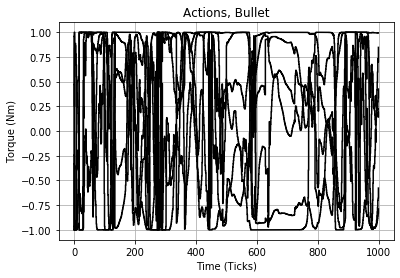

tensor([-0.2414, -0.9626, -0.3300,  0.9587,  0.4721, -0.9991])


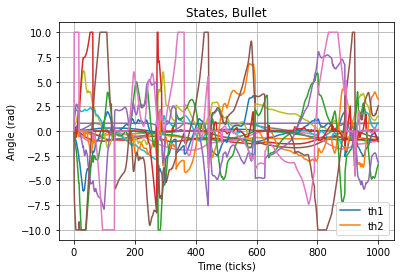

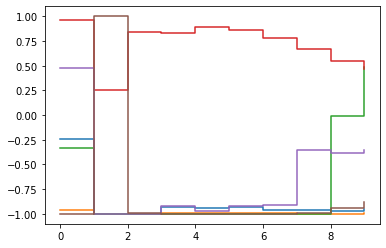

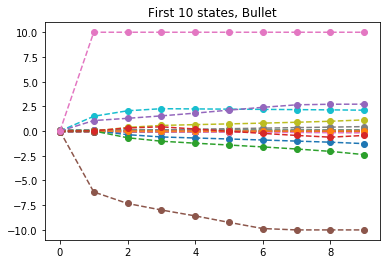

In [33]:
model = model_list[7]
df = df_list[7]
plt.plot(df['r']); plt.show()

obs_hist, act_hist, rew_hist = do_rollout_pb(render=True)

print(f"reward sum: {sum(rew_hist)}")

plt.step(act_hist, 'k', where='post')
plt.title('Actions, Bullet')
plt.xlabel('Time (Ticks)')
plt.ylabel('Torque (Nm)')
plt.grid()
#plt.savefig(script_path + '../figs/act_hist.png')
plt.show(); plt.figure()

plt.plot(obs_hist)

plt.title('States, Bullet')
plt.xlabel('Time (ticks)')
plt.ylabel('Angle (rad)')
plt.legend(['th1', 'th2'])
plt.grid()


#plt.savefig(script_path + '../figs/obs_hist.png')
plt.figure()

le=10
plt.step([t for t in range(le)], act_hist[0:le], where='post')
plt.figure()
plt.plot(obs_hist[0:le], "o--")
plt.title(f"First {le} states, Bullet")

print(act_hist[0])